In [62]:
import tensorflow as tf
import json
import numpy as np
import pandas as pd

from google.cloud import bigquery
from google.cloud import storage

from google.cloud import aiplatform


import matplotlib.pyplot as plt
import seaborn as sns
#https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/custom/custom-tabular-bq-managed-dataset.ipynb

In [63]:
print(tf.__version__)

2.11.0


In [64]:
unUsedColtoPredict=['severity','id','severity_id','severity_name','imported_at']
isLocalModel=True

isBQToCSV=False

filePath='../../data/New_Incident.csv'

modelFile_endPoint=1 
#1=local(dev)/gcs(clound function) and 2=vertext

localFile=True


projectId='smart-data-ml'
dataset_id='SMartML'
table_id='new_incident'

REGION="asia-southeast1"

In [65]:
from google.oauth2 import service_account
mycredentials = service_account.Credentials.from_service_account_file(r'C:\Windows\smart-data-ml-91b6f6204773.json')

if isBQToCSV:
    
    
    bqclient= bigquery.Client(project=projectId,credentials=mycredentials)
    def download_table(bq_table_uri: str):

        prefix = "bq://"
        if bq_table_uri.startswith(prefix):
            bq_table_uri = bq_table_uri[len(prefix) :]

        table = bigquery.TableReference.from_string(bq_table_uri)
        rows = bqclient.list_rows(table)
        return rows.to_dataframe()

    dfNewData=download_table(f"{projectId}.{dataset_id}.{table_id}")
    dfNewData.to_csv(filePath,index=False)    
    print(dfNewData.info())


# Load and Map Data Test

In [66]:
if  localFile:
    dfNewData=pd.read_csv(filePath)

# dfNewData=dfNewData.sample(3)

In [67]:
mapping_file="incident_sevirity_to_class.json"

def download_map_severity_class_as_dict():
 
    storage_client = storage.Client()
    buckdfNewData = storage_client.bucket("smart-ml-pongthorn")
    blob = bucket.blob(mapping_file)
    blob.download_to_filename(mapping_file)
    with open(mapping_file, 'r') as file:
            return json.loads(file.read())

if  localFile==False:    
    map_sevirity_to_class= download_map_severity_class_as_dict()
else:
   with open(mapping_file, 'r') as json_file:
     map_sevirity_to_class= json.load(json_file)
                                  
                                  
print(map_sevirity_to_class)


{'Cosmatic': 0, 'Minor': 1, 'Major': 2, 'Critical': 3}


In [68]:
dfNewData.insert(2, 'severity', dfNewData['severity_name'].map(map_sevirity_to_class),True)
print(dfNewData.info())
dfNewData.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         203 non-null    int64  
 1   severity_id                203 non-null    int64  
 2   severity                   203 non-null    int64  
 3   severity_name              203 non-null    object 
 4   sla                        203 non-null    object 
 5   product_type               203 non-null    object 
 6   brand                      203 non-null    object 
 7   service_type               203 non-null    object 
 8   incident_type              203 non-null    object 
 9   open_to_close_hour         203 non-null    float64
 10  response_to_resolved_hour  203 non-null    float64
 11  imported_at                203 non-null    object 
dtypes: float64(2), int64(3), object(7)
memory usage: 19.2+ KB
None


,id,severity_id,severity,severity_name,sla,product_type,brand,service_type,incident_type,open_to_close_hour,response_to_resolved_hour,imported_at
198,2603,2,2,Major,24x7 4Hrs Response Time,Storage,HPE,Incident,Network Card Failure,54.500000,54.250000,2023-04-10 18:00:05.460437
199,2613,2,2,Major,24x7 4Hrs Resolution Time,Server,HPE,Incident,Hard Disk Drive Failure,7.000000,5.000000,2023-04-10 18:00:05.460437
200,2601,2,2,Major,24x7 6Hrs Resolution Time,Server,HPE,Incident,General Incident,26.416667,26.233333,2023-04-10 18:00:05.460437
201,131,3,1,Minor,24x7 4Hrs Response Time,Storage,NetApp,Incident,OS / Firmware,10705.516667,10705.000000,2023-04-10 18:00:05.460437
202,2594,3,1,Minor,24x7 6Hrs Resolution Time,Software,eUnite,Incident,Software,29.766667,29.750000,2023-04-10 18:00:05.460437


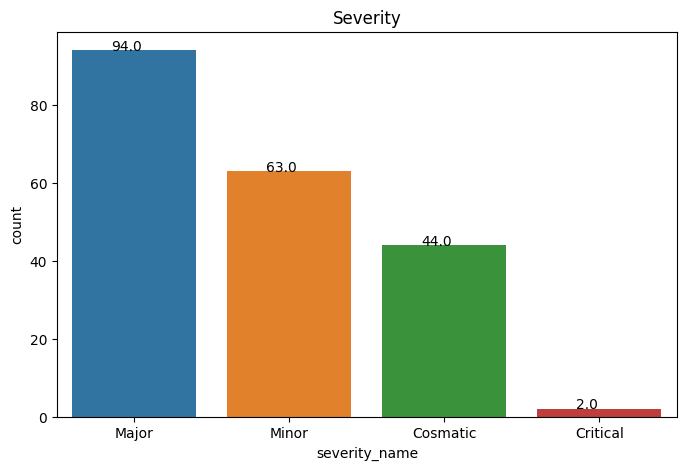

In [69]:
def plot_class(df):
    fig , ax = plt.subplots(figsize=(8,5))
    ax =sns.countplot(x='severity_name', data=df,)
    for p in ax.patches:
       ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
    plt.title('Severity')
    plt.show()
    
plot_class(dfNewData)

In [70]:
pdPrediction=pd.DataFrame(columns=['_id','_predict_severity'])
pdPrediction

,_id,_predict_severity


# Load Model from Directory to Predict

In [71]:
if modelFile_endPoint==1 :

    if  isLocalModel: # Window Enviroment
        PATH_FOLDER_ARTIFACTS="tuned_model"    
    else: # For running on Vertex AI Notebook t
        PATH_FOLDER_ARTIFACTS="gs://tf1-incident-pongthorn/model"

    model = tf.keras.models.load_model(PATH_FOLDER_ARTIFACTS)    
    print(f"Load from {PATH_FOLDER_ARTIFACTS}")
    # model.summary()

    
    for  row_dict in dfNewData.to_dict(orient="records"):
          incident_id=row_dict['id']
          print(f"{incident_id} - {row_dict['severity']}({row_dict['severity_name']})") 
          for key_removed in unUsedColtoPredict:
           row_dict.pop(key_removed)
          # print(row_dict)  

          input_dict = {name: tf.convert_to_tensor([value]) for name, value in row_dict.items()}


          predictionResult = model.predict(input_dict)
          # print(f"{predictionResult}")   
          # maxResult=np.max(arryResult)
          # maxResult=round( maxResult,4)
          # print(f"{maxResult} of {arryResult}")

          prob = tf.nn.softmax(predictionResult)
          prob_pct=(100 * prob)  
          _class = tf.argmax(predictionResult,-1).numpy()[0]
          
          pdPrediction =pd.concat([pdPrediction,pd.DataFrame.from_dict([{'_id':incident_id, '_predict_severity':_class}])] )
          # print(input_dict)  
            
          print(f"{prob_pct} %   as {_class}")     
          print("======================================================================================")

    dfPredictData=pd.merge(dfNewData,pdPrediction,how='inner',left_on='id',right_on='_id')
    dfPredictData=dfPredictData.drop(columns=['_id'])
    dfPredictData=dfPredictData[['id','_predict_severity','severity','severity_name']]


Load from tuned_model
2450 - 2(Major)
1/1 [==============================] - 0s 433ms/step
[[47.53668  17.487772 17.487768 17.487768]] %   as 0
2456 - 2(Major)
1/1 [==============================] - 0s 39ms/step
[[47.535084 17.488728 17.48817  17.488026]] %   as 0
2555 - 2(Major)
1/1 [==============================] - 0s 56ms/step
[[20.930138 38.529335 21.880774 18.659754]] %   as 1
2391 - 2(Major)
1/1 [==============================] - 0s 55ms/step
[[18.275938 19.19765  43.87471  18.651693]] %   as 2
2403 - 2(Major)
1/1 [==============================] - 0s 47ms/step
[[18.179794 19.259329 44.244026 18.31685 ]] %   as 2
2084 - 2(Major)
1/1 [==============================] - 0s 58ms/step
[[17.560791 17.692644 47.206413 17.54015 ]] %   as 2
2426 - 2(Major)
1/1 [==============================] - 0s 48ms/step
[[18.039522 18.873398 44.16584  18.921238]] %   as 2
2388 - 2(Major)
1/1 [==============================] - 0s 54ms/step
[[18.005753 18.841284 44.464348 18.688622]] %   as 2
2447 - 2(

# Load Model from Online EndPpint to Predict

In [72]:
# instances = []
# dfX=dfNewData.drop(columns=unUsedColtoPredict)
# for index,row in dfX.iterrows():
#     dict_item=row.to_dict()
#     instance = {}
#     for key, value in dict_item.items():
#         if key in unUsedColtoPredict:
#             continue
#         if value is None:
#             value = ""
#         instance[key] = [value]
#         # instance[key] = value
#     instances.append(instance)

# print(len(instances))
# print(instances[0])

In [73]:
isEndpointAvaiable=False
listRequestData=[]
try:
    ENDPOINT_ID="2704182877817405440"
    endpoint = aiplatform.Endpoint(endpoint_name=f"projects/{projectId}/locations/{REGION}/endpoints/{ENDPOINT_ID}"
                                   ,credentials=mycredentials)
    print(endpoint)
    isEndpointAvaiable=True
except Exception as error:
    print(str(error))
    
if modelFile_endPoint==2 and isEndpointAvaiable==True :

    for data in dfNewData.to_dict(orient="records"):
        incident_id=data['id']
        severity=data['severity']
        severity_name=data['severity_name']
        # convert dict to tf format
        request_data = {key : [value] for key,value in data.items() }
        for key_removed in unUsedColtoPredict:
           request_data.pop(key_removed)
        request_data = json.dumps(request_data)
        listRequestData.append(request_data)
        print(request_data)

        response = endpoint.predict([request_data])
        y_predicted = np.argmax(response.predictions, axis=1)
        predictionResult=response[0][0]
        print(predictionResult)
        print(y_predicted)

        pdPrediction =pd.concat([pdPrediction,pd.DataFrame.from_dict([{'_id':incident_id, '_predict_severity':y_predicted[0]}])] )
        print("======================================================================================")

    dfPredictData=pd.merge(dfNewData,pdPrediction,how='inner',left_on='id',right_on='_id')
    dfPredictData=dfPredictData.drop(columns=['_id'])
    dfPredictData=dfPredictData[['id','_predict_severity','severity','severity_name']]       
else:
     print("No endpoint to predict  as online predction")     

404 Endpoint projects/smart-data-ml/locations/asia-southeast1/endpoints/2704182877817405440 is not found.
No endpoint to predict  as online predction


# Load model by refering to vertext-ai registry

In [74]:
# MODEL_ID="2102389377610022912"
# MODEL_URI =  f'projects/{PROJECT_NUMBER}/locations/{REGION}/models/{MODEL_ID}'
# print(MODEL_URI)

# model = aiplatform.Model(MODEL_URI)


In [75]:
# !gsutil -m cp \
#   "gs://tf1-incident-pongthorn/batch_prediction/output_batch/prediction-tf1_dnn_incident_yip-2023_03_28T05_55_06_072Z/prediction.errors_stats-00000-of-00001" \
#   "gs://tf1-incident-pongthorn/batch_prediction/output_batch/prediction-tf1_dnn_incident_yip-2023_03_28T05_55_06_072Z/prediction.results-00000-of-00001" \
#   .

# Classification Rerport

In [76]:
from sklearn.metrics import confusion_matrix,classification_report


In [77]:
dfPredictData

,id,_predict_severity,severity,severity_name
0,2450,0,2,Major
1,2456,0,2,Major
2,2555,1,2,Major
3,2391,2,2,Major
4,2403,2,2,Major
...,...,...,...,...
252,2603,2,2,Major
253,2613,3,2,Major
254,2601,2,2,Major
255,131,2,1,Minor


In [78]:
className=list(set().union(list(dfPredictData['severity'].unique()),list(dfPredictData['_predict_severity'].unique())))
actualClass=[  f'actual-{x}' for x in  className]
predictedlClass=[  f'predcited-{x}' for x in className]

y_true=list(dfPredictData['severity'])
y_pred=list(dfPredictData['_predict_severity'])
cnf_matrix = confusion_matrix(y_true,y_pred)
cnf_matrix

# #index=actual , column=prediction
cm_df = pd.DataFrame(cnf_matrix,
                     index = actualClass, 
                     columns = predictedlClass)
cm_df

,predcited-0,predcited-1,predcited-2,predcited-3
actual-0,34,19,5,0
actual-1,3,34,39,1
actual-2,2,30,82,4
actual-3,0,0,4,0


In [79]:

print(classification_report(y_true, y_pred, labels=className))

              precision    recall  f1-score   support

           0       0.87      0.59      0.70        58
           1       0.41      0.44      0.42        77
           2       0.63      0.69      0.66       118
           3       0.00      0.00      0.00         4

    accuracy                           0.58       257
   macro avg       0.48      0.43      0.45       257
weighted avg       0.61      0.58      0.59       257

